### Spatial mapping of human lung region snRNA-seq to Visium (for Elo) - with scVI non-amortised inference

In [1]:
import sys
sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/BayraktarLab/cell2location/')

import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib as mpl

import cell2location
#import scvi

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
import seaborn as sns

Global seed set to 0


`THEANO_FLAGS='force_device=True'` forces the package to use GPU. Pay attention to error messages that might indicate theano failed to initalise the GPU.   
Do not forget to change `device=cuda4` to your available GPU id. Use `device=cuda` / `device=cuda0` if you have just one locally or if you are requesting one GPU via HPC cluster job.

### Outline

1. Loading Visium data and single cell reference
2. Show UMAP of cells and locations
3. cell2location analysis in one step
4. Automatic discrete region identification by clustering cell densities
5. Visualize cell type density gradients using diffusion maps
6. Identify co-occuring cell type combinations using matrix factorisation



## 1. Loading Visium data and single cell reference

First let's read spatial Visium data from 10X Space Ranger output. Here we load sample annotations.

In [2]:
sp_data_folder = '/nfs/team205/vk7/sanger_projects/large_data/lung_airway_km/regions_with_visium_all/'
sc_data_folder = '/nfs/team205/vk7/sanger_projects/large_data/lung_airway_km/'
results_folder = '/nfs/team205/vk7/sanger_projects/collaborations/adult_lung_mapping/results/'
scvi_ref_run_name = f'{results_folder}/non_amortised/v0_Adam_4000iter_snsc_selection_CCLplasma_v4Ref'
scvi_run_name = f'{results_folder}/non_amortised/v3_nonamortised_Adam_alpha20_40k_lr0002_CCLplasma_long_v4Ref_wo_lowQ_scaledELBO_100k'

annotation_folder = '/nfs/team205/vk7/sanger_projects/collaborations/adult_lung_mapping/data/Loupe_annotations/'
image_folder = '/nfs/team205/vk7/sanger_projects/collaborations/adult_lung_mapping/data/original_histology/Images_16/'

# path for plots
fig_path = f'{scvi_run_name}/plots/figures/'
fig_path

'/nfs/team205/vk7/sanger_projects/collaborations/adult_lung_mapping/results//non_amortised/v3_nonamortised_Adam_alpha20_40k_lr0002_CCLplasma_long_v4Ref_wo_lowQ_scaledELBO_100k/plots/figures/'

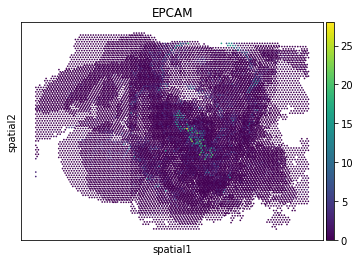

In [3]:
adata_vis = sc.read_h5ad(f'{scvi_run_name}/sp.h5ad')
#mod = cell2location.models.Cell2location.load(scvi_run_name, adata_vis)

# add 5% quantile, representing confident cell abundance, 'at least this amount is present', 
# to adata.obs with nice names for plotting
adata_vis.obs[adata_vis.uns['mod']['factor_names']] = adata_vis.obsm['q05_cell_abundance_w_sf']

# plot everything to get rid of warnings later
sc.pl.spatial(adata_vis, 
              color=["EPCAM"], img_key=None,
              vmin=0, library_id='WSA_LngSP9258467',
              gene_symbols='SYMBOL'
             )

In [4]:
image_annot = pd.read_csv(f'{image_folder}Visium_metadata.csv', index_col='Sequencing_ID')
adata_vis.obs['image_name_i'] = image_annot.reindex(index=adata_vis.obs['sample'].values)['Image'].values

## Spatial plots per cell type

/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initia

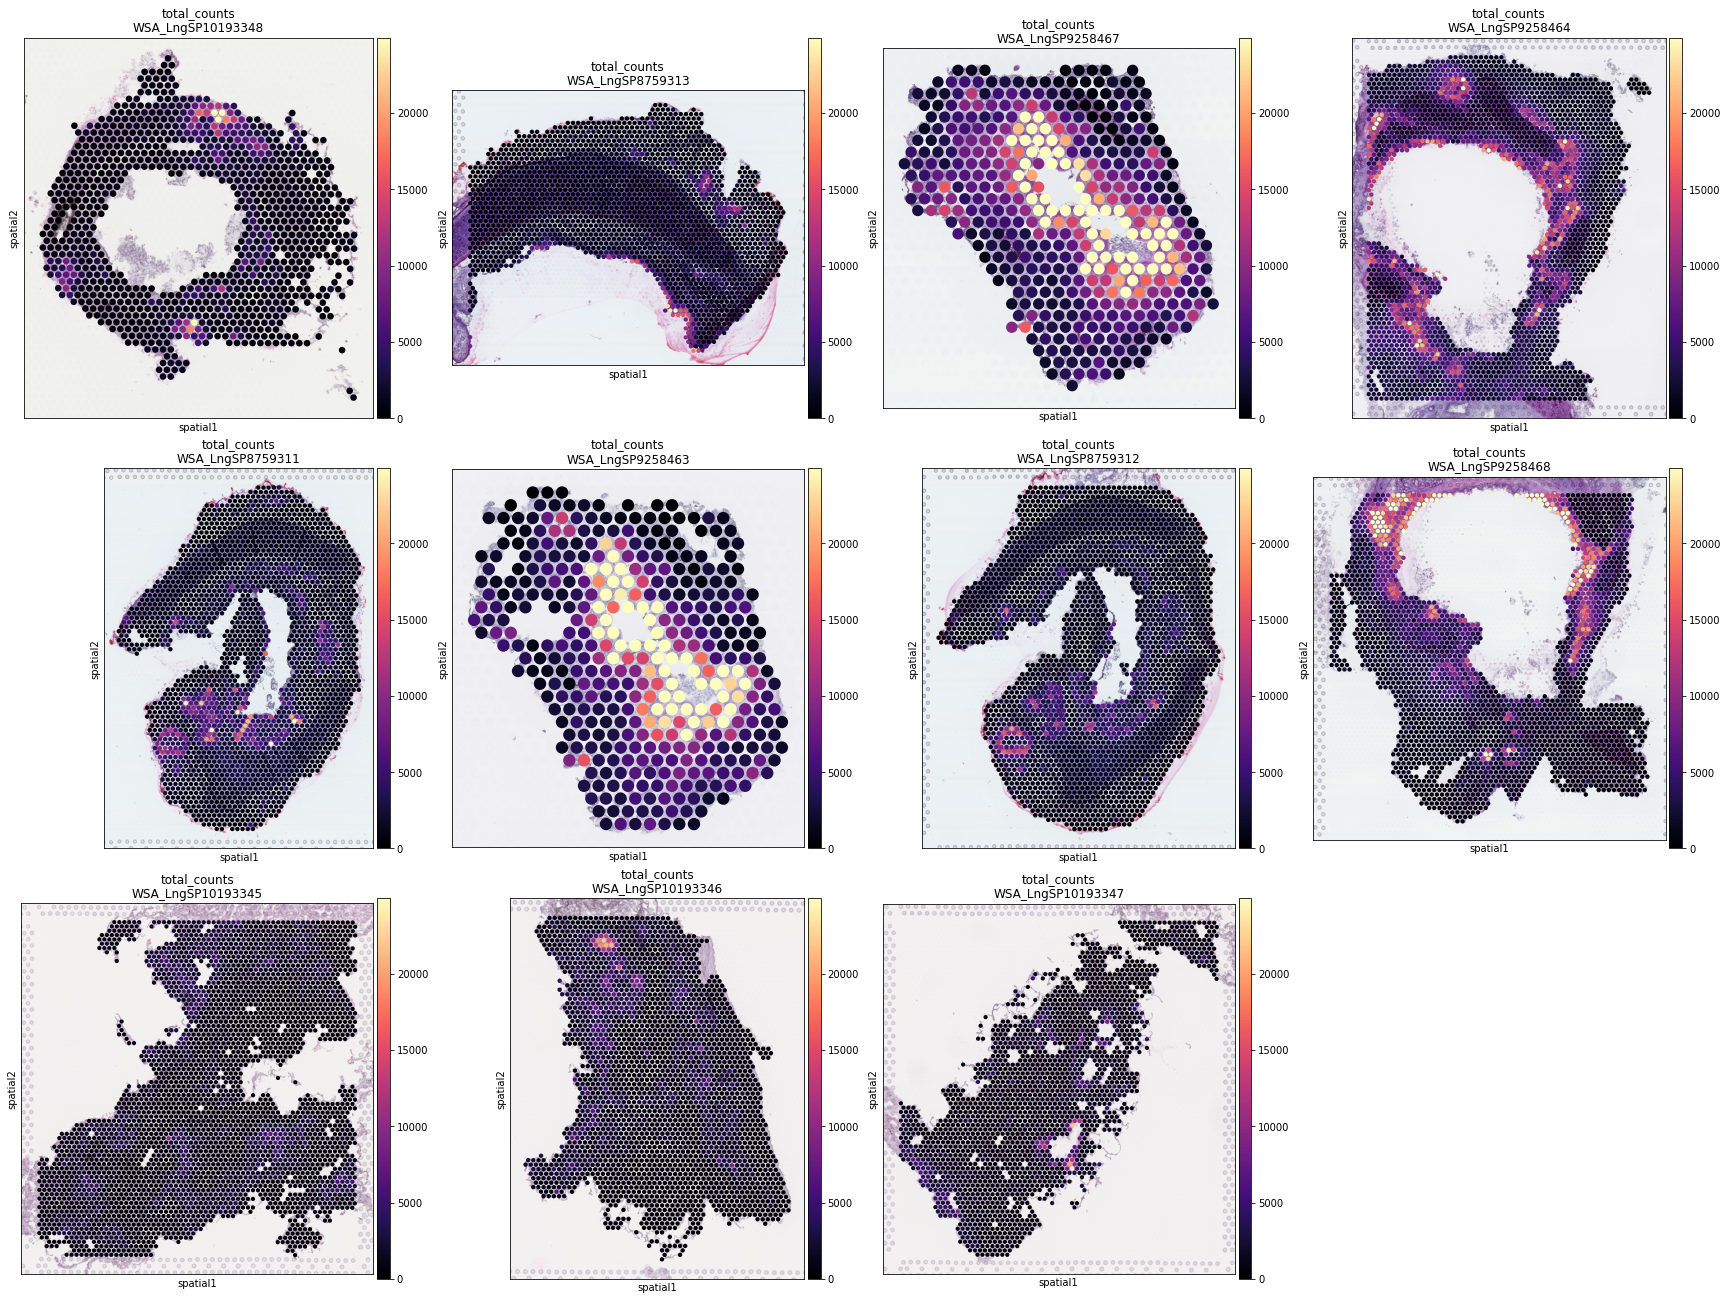

In [5]:
# defining useful function
def select_slide(adata, s, s_col='sample'):
    r""" Select data for one slide from the spatial anndata object.

    :param adata: Anndata object with multiple spatial samples
    :param s: name of selected sample
    :param s_col: column in adata.obs listing sample name for each location
    """

    slide = adata[adata.obs[s_col].isin([s]), :]
    s_keys = list(slide.uns['spatial'].keys())
    s_spatial = np.array(s_keys)[[s in k for k in s_keys]][0]

    slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}

    return slide

# identify spot locations to crop near tissue
def get_crop_coord(slide, scale='tissue_hires_scalef'):

    crop_max = (slide.obsm['spatial'] * list(slide.uns['spatial'].values())[0]['scalefactors'][scale]).max(axis=0)
    crop_min = (slide.obsm['spatial'] * list(slide.uns['spatial'].values())[0]['scalefactors'][scale]).min(axis=0)

    crop_x = [crop_min[0]-0, crop_max[0]+0]
    crop_y = [crop_min[1]-0, crop_max[1]+0]

    return crop_x, crop_y
    

def plot_spatial_per_cell_type(adata, 
                               cell_type='total_counts',
                               samples=[
       'WSA_LngSP10193348', 'WSA_LngSP8759311', 'WSA_LngSP10193345',
                                    
       'WSA_LngSP8759313', 'WSA_LngSP9258463', 'WSA_LngSP10193346',
                                   
       'WSA_LngSP9258467', 'WSA_LngSP8759312', 'WSA_LngSP10193347',
                                   
       'WSA_LngSP9258464', 'WSA_LngSP9258468',
                               ],
                              ncol=4, prefix='', figsize=(24, 18),
                              vmax_quantile=0.992):
    n_samples = len(samples)
    nrow = int(np.ceil(n_samples / ncol))
    fig, axs = plt.subplots(nrow, ncol, figsize=figsize)
    if nrow == 1:
        axs = axs.reshape((1, ncol))
    
    col_name = f'{prefix}{cell_type}'
    vmax = np.quantile(adata_vis.obs[col_name].values, vmax_quantile)
    adata_vis.obs[cell_type] = adata_vis.obs[col_name].copy()
    
    from itertools import chain
    ind = list(chain(*[[(i, j) for i in range(nrow)] for j in range(ncol)]))
    
    for i, s in enumerate(samples):
        sp_data_s = select_slide(adata, s, s_col='sample')
        sc.pl.spatial(sp_data_s, cmap='magma',
                      color=cell_type, 
                      size=1.3, img_key='hires', alpha_img=1,
                      vmin=0, vmax=vmax, ax=axs[ind[i][0],ind[i][1]], show=False
                                            )
        axs[ind[i][0],ind[i][1]].title.set_text(cell_type+'\n'+s)
        
    if len(samples) < len(axs.flatten()):
        for i in range(len(samples), len(axs.flatten())):
            axs[ind[i][0],ind[i][1]].axis('off')
        
    fig.tight_layout(pad=0.5)
        
    return fig

plot_spatial_per_cell_type(adata_vis, cell_type='total_counts');

List cell type names

In [6]:
adata_vis.uns['mod']['factor_names']#.to_csv('./factor_names')

array(['AT1', 'AT2', 'B_memory', 'B_naive', 'B_plasma_IgA',
       'B_plasma_IgG', 'B_plasmablast', 'Basal', 'CD4_EM_Effector',
       'CD4_TRM', 'CD4_naive_CM', 'CD8_EM', 'CD8_EM_EMRA', 'CD8_TRM_EM',
       'CD8_TRM', 'Chondrocyte', 'Ciliated', 'DC_1', 'DC_2',
       'DC_activated', 'DC_plasmacytoid', 'Deuterosomal', 'Dividing_AT2',
       'Dividing_Basal', 'Endothelia_Lymphatic',
       'Endothelia_vascular_Cap_a', 'Endothelia_vascular_Cap_g',
       'Endothelia_vascular_arterial_pulmonary',
       'Endothelia_vascular_arterial_systemic',
       'Endothelia_vascular_venous_pulmonary',
       'Endothelia_vascular_venous_systemic', 'Erythrocyte',
       'Fibro_adventitial', 'Fibro_alveolar', 'Fibro_immune_recruiting',
       'Fibro_myofibroblast', 'Fibro_peribronchial',
       'Fibro_perichondrial', 'ILC', 'Ionocyte_n_Brush', 'MAIT',
       'Macro_CHIT1', 'Macro_interstitial', 'Macro_AW_CX3CR1',
       'Macro_alveolar_metallothioneins', 'Macro_alv', 'Macro_dividing',
       'Macro_int'

### Multi-colour spatial plot

/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


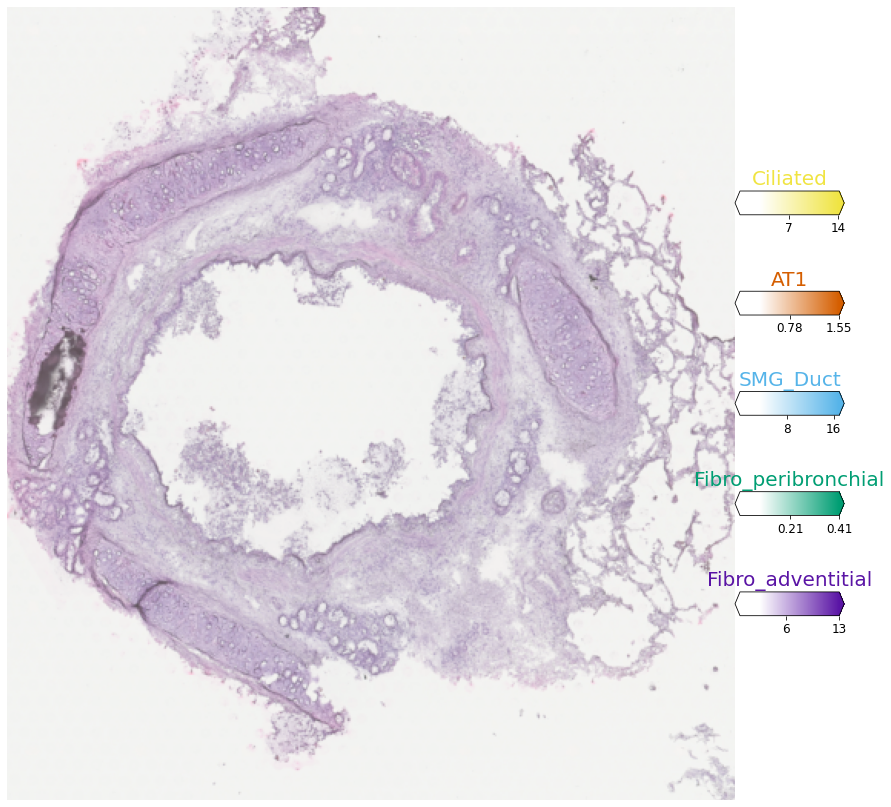

In [7]:
from cell2location.plt.mapping_video import plot_spatial

# select up to 5-6 clusters (the last colour is grey)
sel_clust = ['Ciliated', 'AT1', 'SMG_Duct', 'Fibro_peribronchial', 'Fibro_adventitial']
sel_clust_col = ['' + str(i) for i in sel_clust]

slide = select_slide(adata_vis, 'WSA_LngSP10193348')
crop_x, crop_y = get_crop_coord(slide, scale='tissue_hires_scalef')

with mpl.rc_context({'figure.figsize': (15, 15)}):
    fig = plot_spatial(slide.obs[sel_clust_col], labels=sel_clust,
                  coords=slide.obsm['spatial'],
                  show_img=True, img_alpha=0.8,
                  max_color_quantile=0.995,
                  crop_x=crop_x, crop_y=crop_y,
                  style='fast', # fast or dark_background
                  img=list(slide.uns['spatial'].values())[0]['images']['hires'],
                  circle_diameter=12, colorbar_position='right')
    plt.savefig(f'{fig_path}/FigS26_with_zoom_ins{"_".join(sel_clust)}.pdf', bbox_inches='tight')

/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


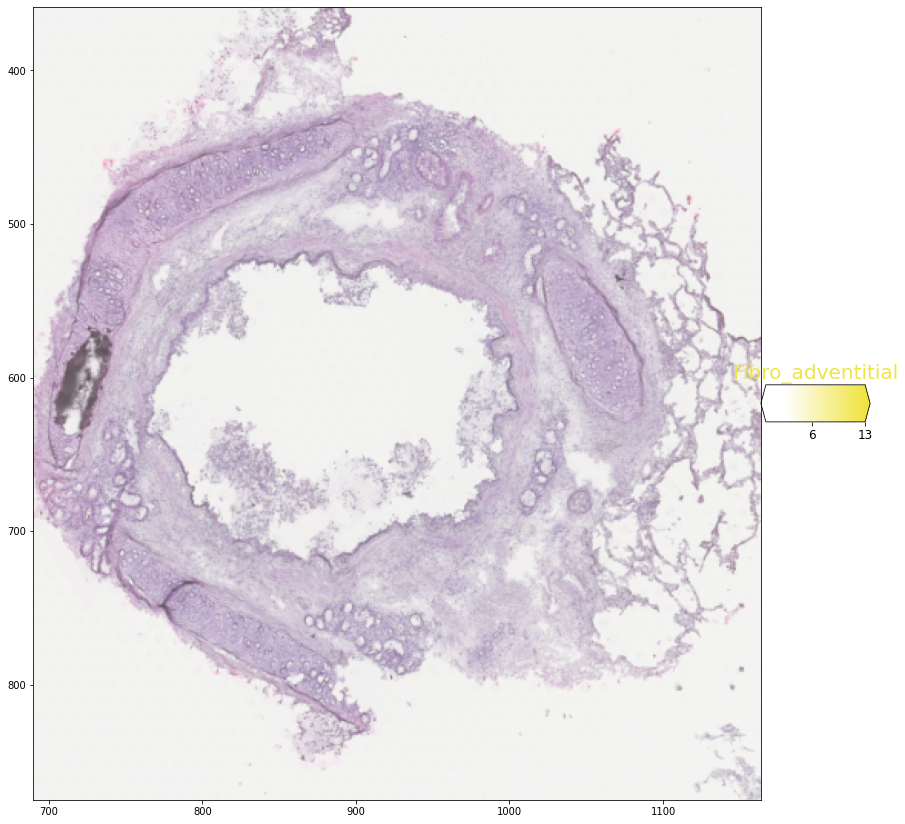

In [8]:
from cell2location.plt.mapping_video import plot_spatial

# select up to 5-6 clusters (the last colour is grey)
sel_clust = ['Fibro_adventitial']
sel_clust_col = ['' + str(i) for i in sel_clust]

slide = select_slide(adata_vis, 'WSA_LngSP10193348')
crop_x, crop_y = get_crop_coord(slide, scale='tissue_hires_scalef')

with mpl.rc_context({'figure.figsize': (15, 15)}):
    fig = plot_spatial(slide.obs[sel_clust_col], labels=sel_clust,
                  coords=slide.obsm['spatial'],
                  show_img=True, img_alpha=0.8,
                  plt_axis='on',
                  max_color_quantile=0.995,
                  crop_x=crop_x, crop_y=crop_y,
                  style='fast', # fast or dark_background
                  img=list(slide.uns['spatial'].values())[0]['images']['hires'],
                  circle_diameter=12, colorbar_position='right')
    #plt.savefig(f'{fig_path}/FigS26_with_zoom_ins{"_".join(sel_clust)}.pdf', bbox_inches='tight')

/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


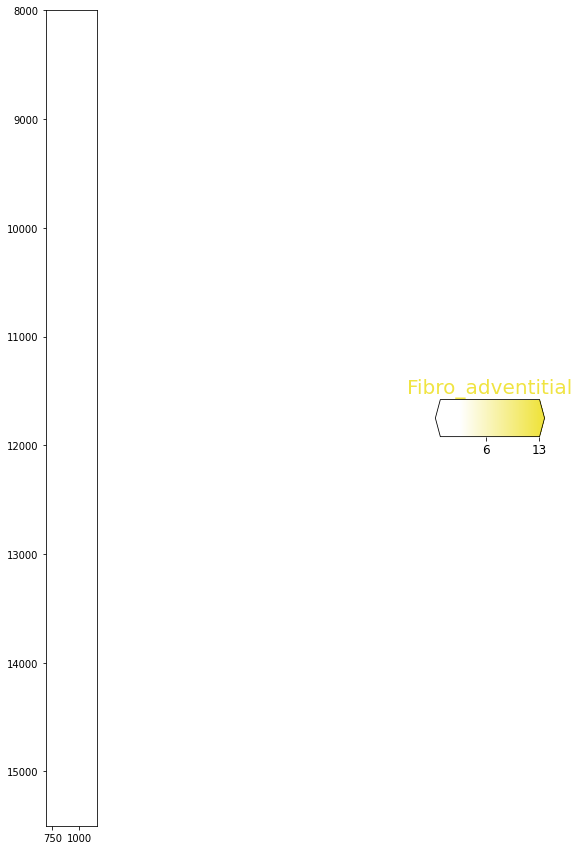

In [9]:
from cell2location.plt.mapping_video import plot_spatial

# select up to 5-6 clusters (the last colour is grey)
sel_clust = ['Fibro_adventitial']
sel_clust_col = ['' + str(i) for i in sel_clust]

slide = select_slide(adata_vis, 'WSA_LngSP10193348')
crop_x, crop_y = get_crop_coord(slide, scale='tissue_hires_scalef')
crop_y = [8000, 15500]

with mpl.rc_context({'figure.figsize': (15, 15)}):
    fig = plot_spatial(slide.obs[sel_clust_col], labels=sel_clust,
                  coords=slide.obsm['spatial'],
                  show_img=True, img_alpha=0.8,
                  plt_axis='on',
                  max_color_quantile=0.995,
                  crop_x=crop_x, crop_y=crop_y,
                  style='fast', # fast or dark_background
                  img=list(slide.uns['spatial'].values())[0]['images']['hires'],
                  circle_diameter=12, colorbar_position='right')
    #plt.savefig(f'{fig_path}/FigS26_with_zoom_ins{"_".join(sel_clust)}.pdf', bbox_inches='tight')

## Pearson R analysis

In [10]:
expected = mod.module.model.compute_expected(
    samples=adata_vis.uns['mod']['post_sample_means'], 
    adata_manager=mod.adata_manager, 
    ind_x=None,
    hide_ambient=False, hide_cell_type=False,
)
expected_ambient = mod.module.model.compute_expected(
    samples=adata_vis.uns['mod']['post_sample_means'], 
    adata_manager=mod.adata_manager, 
    ind_x=None,
    hide_ambient=False, hide_cell_type=True,
)
expected_cell_type = mod.module.model.compute_expected(
    samples=adata_vis.uns['mod']['post_sample_means'], 
    adata_manager=mod.adata_manager, 
    ind_x=None,
    hide_ambient=True, hide_cell_type=False,
)

total_variance = (adata_vis.X.toarray() + 1e-9).var(axis=0)
model_variance = (expected['mu'] + 1e-9).var(axis=0)
ambient_variance = (expected_ambient['mu'] + 1e-9).var(axis=0)
cell_type_variance = (expected_cell_type['mu'] + 1e-9).var(axis=0)

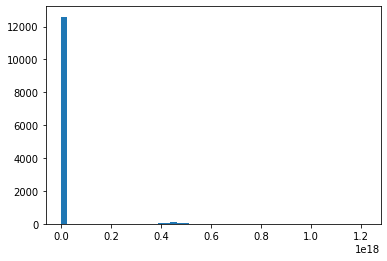

In [11]:
plt.hist(model_variance / total_variance, bins=50);

In [12]:
np.median((model_variance / total_variance))

0.18913288

In [13]:
(model_variance / total_variance).mean()

1.1269467e+16

In [14]:
total_variance = (adata_vis.X.toarray() + 1e-9).var()
model_variance = (expected['mu'] + 1e-9).var()
ambient_variance = (expected_ambient['mu'] + 1e-9).var()
cell_type_variance = (expected_cell_type['mu'] + 1e-9).var()

In [15]:
model_variance / total_variance

0.542115

In [16]:
# very low amount of variance explained by ambient model
ambient_variance / model_variance

3.3270646566196706e-05

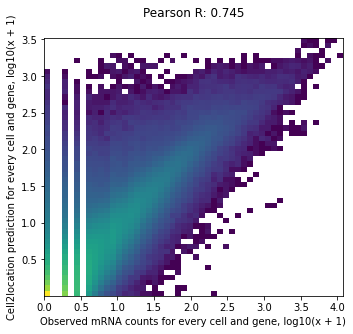

In [17]:
data_node = adata_vis.X.toarray().flatten()
mu = expected['mu'].flatten()

def transform(x):
    return np.log10(x + 1)

corr = np.round(np.corrcoef(transform(data_node), transform(mu))[0,1], 3)

with mpl.rc_context({'figure.figsize': (5, 5)}):
    plt.hist2d(
        transform(data_node), transform(mu), bins=50, norm=mpl.colors.LogNorm()
    )
    plt.gca().set_aspect("equal", adjustable="box")
    plt.xlabel("Observed mRNA counts for every cell and gene, log10(x + 1)")
    plt.ylabel("Cell2location prediction for every cell and gene, log10(x + 1)")
    plt.title(f"Pearson R: {corr}\n") #Variance explained: {model_variance / total_variance}")
    plt.tight_layout()

### Dotplot by histology-based annotation

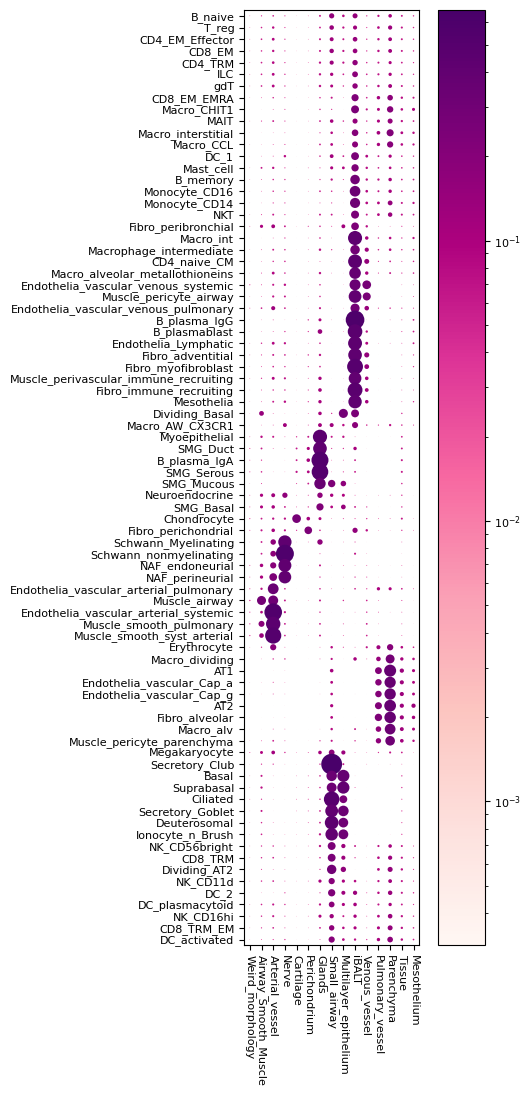

In [10]:
fig_dir = f'{scvi_run_name}/plots/'

annot_ = ['Tissue', 'Perichondrium', 'Cartilage', 'Glands',
       'Multilayer_epithelium', 'Airway_Smooth_Muscle', 'Weird_morphology',
       'Nerve', 'Venous_vessel', 'Arterial_vessel', 'Parenchyma',
       'Mesothelium', 'Pulmonary_vessel', 'Small_airway', 'iBALT']

annot_abundance_df = pd.DataFrame(index=adata_vis.uns['mod']['factor_names'],
                                  columns=annot_)
for a in annot_:
    ind = adata_vis.obs[a] == True
    annot_abundance_df[a] = adata_vis.obs.loc[ind, adata_vis.uns['mod']['factor_names']].mean(0)
    
annot_abundance_norm = (annot_abundance_df.T / annot_abundance_df.sum(1)).T

mpl.rc_file_defaults()
mpl.rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
with mpl.rc_context({'font.size': 8, 'axes.facecolor': "white"}):
    from cell2location.plt.plot_heatmap import clustermap
    annot_abundance_norm_order = clustermap(annot_abundance_norm, figure_size=(5, 11), 
               cmap='RdPu', log=True, fun_type='dotplot',
               cluster_rows=True, cluster_cols=True,
               return_linkage=True
              )
    plt.savefig(f"{fig_dir}histology_annotation_dotplot.pdf",
                    bbox_inches='tight')
    plt.show()

In [11]:
adata_vis.uns['mod']['factor_names'], adata_vis.uns['mod']['factor_names'].shape

(array(['AT1', 'AT2', 'B_memory', 'B_naive', 'B_plasma_IgA',
        'B_plasma_IgG', 'B_plasmablast', 'Basal', 'CD4_EM_Effector',
        'CD4_TRM', 'CD4_naive_CM', 'CD8_EM', 'CD8_EM_EMRA', 'CD8_TRM_EM',
        'CD8_TRM', 'Chondrocyte', 'Ciliated', 'DC_1', 'DC_2',
        'DC_activated', 'DC_plasmacytoid', 'Deuterosomal', 'Dividing_AT2',
        'Dividing_Basal', 'Endothelia_Lymphatic',
        'Endothelia_vascular_Cap_a', 'Endothelia_vascular_Cap_g',
        'Endothelia_vascular_arterial_pulmonary',
        'Endothelia_vascular_arterial_systemic',
        'Endothelia_vascular_venous_pulmonary',
        'Endothelia_vascular_venous_systemic', 'Erythrocyte',
        'Fibro_adventitial', 'Fibro_alveolar', 'Fibro_immune_recruiting',
        'Fibro_myofibroblast', 'Fibro_peribronchial',
        'Fibro_perichondrial', 'ILC', 'Ionocyte_n_Brush', 'MAIT',
        'Macro_CHIT1', 'Macro_interstitial', 'Macro_AW_CX3CR1',
        'Macro_alveolar_metallothioneins', 'Macro_alv', 'Macro_dividing',
  

## Compared Pearson R between cell2location and observed count to Pearson R between replicates of the same tissue area.

In [20]:
annot_ = [
    'Perichondrium', 'Cartilage', 'Glands',
    'Multilayer_epithelium', 'Airway_Smooth_Muscle',
    'Nerve', 'Arterial_vessel',
]
samples = [
    'WSA_LngSP8759312', 'WSA_LngSP9258468', 'WSA_LngSP8759313',
    'WSA_LngSP8759311', 'WSA_LngSP9258467', 'WSA_LngSP9258463',
]

annot_sample_df = pd.DataFrame(
    index=samples,
    columns=annot_
)

for a in annot_:
    ind = adata_vis.obs[a] == True
    annot_sample_df[a] = adata_vis.obs.loc[ind, 'sample'].value_counts(0)
    
annot_sample_df

Perichondrium  Cartilage  Glands  Multilayer_epithelium  \
WSA_LngSP8759312            156        446     148                    130   
WSA_LngSP9258468            214        137     278                    253   
WSA_LngSP8759313            185        612      89                    152   
WSA_LngSP8759311            144        419     149                    122   
WSA_LngSP9258467             53         13      10                     79   
WSA_LngSP9258463             39         18       5                     75   

                  Airway_Smooth_Muscle  Nerve  Arterial_vessel  
WSA_LngSP8759312                   146     20               35  
WSA_LngSP9258468                    88      2               11  
WSA_LngSP8759313                    29     17               35  
WSA_LngSP8759311                   133     22               29  
WSA_LngSP9258467                    11      8               10  
WSA_LngSP9258463                     6      1               10

In [21]:
x = adata_vis.X

annot_sample_df = pd.DataFrame(
    index=samples,
    columns=annot_
)

for a in annot_:
    for s in samples:
        ind_a = adata_vis.obs[a] == True
        ind_s = adata_vis.obs['sample'] == s
        annot_sample_df.loc[s, a] = np.array(x[ind_a & ind_s,:].mean(0)).flatten()

sample_sample_df = pd.DataFrame(
    index=samples,
    columns=samples
)

for s1 in samples:
    for s2 in samples:
        vals_s1 = np.concatenate(annot_sample_df.loc[s1, :].values).flatten()
        vals_s2 = np.concatenate(annot_sample_df.loc[s2, :].values).flatten()
        sample_sample_df.loc[s1, s2] = np.corrcoef(vals_s1, vals_s2)[0, 1]
        
for_barplot = pd.DataFrame()
for_barplot['Pearson_R'] = sample_sample_df.values[np.triu_indices(len(samples), k=1)]
for_barplot['Condition'] = 'Replicates (Bronchi)'

In [22]:
x = expected['mu']

c2l_annot_sample_df = pd.DataFrame(
    index=samples,
    columns=annot_
)

for a in annot_:
    for s in samples:
        ind_a = adata_vis.obs[a] == True
        ind_s = adata_vis.obs['sample'] == s
        c2l_annot_sample_df.loc[s, a] = np.array(x[ind_a & ind_s,:].mean(0)).flatten()

c2l_sample_sample_df = pd.Series(
    index=samples,
)

for s1 in samples:
    vals_s1 = np.concatenate(c2l_annot_sample_df.loc[s1, :].values).flatten()
    vals_s2 = np.concatenate(annot_sample_df.loc[s1, :].values).flatten()
    c2l_sample_sample_df.loc[s1, s2] = np.corrcoef(vals_s1, vals_s2)[0, 1]
    
c2l_for_barplot = pd.DataFrame()
c2l_for_barplot['Pearson_R'] = c2l_sample_sample_df
c2l_for_barplot['Condition'] = 'Cell2location_VS_observed_mRNA_counts'

/tmp/ipykernel_28300/1265067645.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  c2l_sample_sample_df = pd.Series(


<AxesSubplot:xlabel='Condition', ylabel='Pearson_R'>

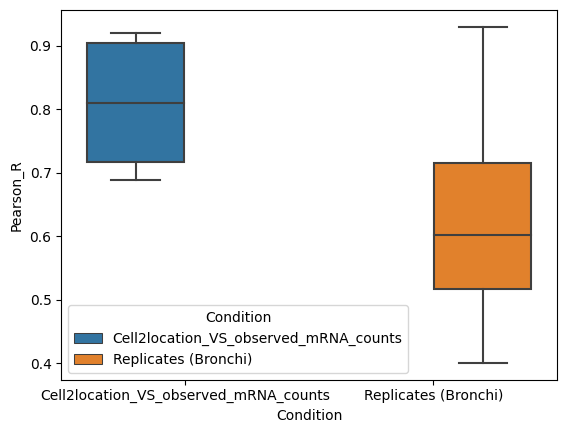

In [23]:
for_barplot = pd.concat([c2l_for_barplot, for_barplot])
sns.boxplot(x='Condition', y='Pearson_R', data=for_barplot, hue='Condition')

## RUN NMF analysis

In [12]:
adata_vis_bronchi = adata_vis[[i in ['WSA_LngSP10193348', 'WSA_LngSP8759311',
                                     'WSA_LngSP8759313', 'WSA_LngSP8759312', 
                                     'WSA_LngSP9258464', 'WSA_LngSP9258468'] 
                               for i in adata_vis.obs['sample']]]

In [13]:
from cell2location import run_colocation
res_dict, adata_vis_bronchi = run_colocation(
    adata_vis_bronchi,
    model_name='CoLocatedGroupsSklearnNMF',
    train_args={
      'n_fact': np.arange(8, 24), # IMPORTANT: use a wider range of the number of factors (5-30)
      'sample_name_col': 'sample', # columns in adata_vis.obs that identifies sample
      'n_restarts': 3 # number of training restarts
    },
    export_args={
        'path': f'{scvi_run_name}/CoLocatedComb_bronchi/',
        'plot_cell_type_loadings_kwargs': {
            'selected_cell_types': adata_vis.uns['mod']['factor_names'][annot_abundance_norm_order['row_ord']],
            'cluster_genes': False,
        },
        'scanpy_alpha_img': 1,
    }
)

### Analysis name: CoLocatedGroupsSklearnNMF_8combinations_12361locations_80factors


/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initial

### Analysis name: CoLocatedGroupsSklearnNMF_9combinations_12361locations_80factors


/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initial

/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


### Analysis name: CoLocatedGroupsSklearnNMF_10combinations_12361locations_80factors


/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initial

/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


### Analysis name: CoLocatedGroupsSklearnNMF_11combinations_12361locations_80factors


/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initial

/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


### Analysis name: CoLocatedGroupsSklearnNMF_12combinations_12361locations_80factors


/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initial

/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


### Analysis name: CoLocatedGroupsSklearnNMF_13combinations_12361locations_80factors


/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initial

/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


### Analysis name: CoLocatedGroupsSklearnNMF_14combinations_12361locations_80factors


/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initial

/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


### Analysis name: CoLocatedGroupsSklearnNMF_15combinations_12361locations_80factors


/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initial

/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


### Analysis name: CoLocatedGroupsSklearnNMF_16combinations_12361locations_80factors


/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initial

/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


### Analysis name: CoLocatedGroupsSklearnNMF_17combinations_12361locations_80factors


/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initial

/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


### Analysis name: CoLocatedGroupsSklearnNMF_18combinations_12361locations_80factors


/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initial

/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


### Analysis name: CoLocatedGroupsSklearnNMF_19combinations_12361locations_80factors


/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initial

/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


### Analysis name: CoLocatedGroupsSklearnNMF_20combinations_12361locations_80factors


/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initial

/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


### Analysis name: CoLocatedGroupsSklearnNMF_21combinations_12361locations_80factors


/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initial

/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


### Analysis name: CoLocatedGroupsSklearnNMF_22combinations_12361locations_80factors


/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initial

/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


### Analysis name: CoLocatedGroupsSklearnNMF_23combinations_12361locations_80factors


/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initial

/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/nfs/team283/vk7/software/miniconda3farm5/envs/test_scvi16_cuda111/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


In [ ]:
from cell2location import run_colocation
res_dict, adata_vis = run_colocation(
    adata_vis,
    model_name='CoLocatedGroupsSklearnNMF',
    train_args={
      'n_fact': [8, 9, 11, 12, 13, 19, 20, 21, 22], # IMPORTANT: use a wider range of the number of factors (5-30)
      'sample_name_col': 'sample', # columns in adata_vis.obs that identifies sample
      'n_restarts': 3 # number of training restarts
    },
    export_args={
        'path': f'{scvi_run_name}/CoLocatedComb/',
        'plot_cell_type_loadings_kwargs': {
            'selected_cell_types': adata_vis.uns['mod']['factor_names'][annot_abundance_norm_order['row_ord']],
            'cluster_genes': False,
        },
        'scanpy_alpha_img': 1,
    }
)

In [ ]:
# Here we plot the NMF weights (Same as saved to `cell_type_fractions_heatmap`)
res_dict['n_fact12']['mod'].plot_cell_type_loadings(
    selected_cell_types=adata_vis.uns['mod']['factor_names'][annot_abundance_norm_order['row_ord']],
    cluster_genes=False,
)

In [ ]:
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes as inset_axes_func


def add_rectange_to_axis(ax, crop_coord, **kwargs):
    width = crop_coord[1] - crop_coord[0]
    height = crop_coord[2] - crop_coord[3]
    bottom_left = (crop_coord[0], crop_coord[3])
    
    kwargs = {'linewidth': 3,
             'edgecolor': 'r',
             'facecolor': 'none',
             'zorder': 10,
             **kwargs}
    
    rect = patches.Rectangle(bottom_left, width, height, **kwargs)
    ax.add_patch(rect)
    

def add_rectangle_to_fig(fig, crop_coord, **kwargs):
    if type(fig) is list:
        axs = fig
    else:
        axs = fig.axes
    for ax in axs:
        if type(ax.get_aspect()) is str or ax.get_aspect() < 5:
            add_rectange_to_axis(ax, crop_coord, **kwargs)

def spatial_with_insets(adata, ct_list, axs=None, crop_tissue=None, crop_inset=None, 
                        hires_scalef=1, mode='lines', linewidth=2.5, quantile=0.997):
    for col, ax in zip(ct_list, axs):
        
        vmax = np.quantile(adata.obs[col].values, quantile)
        
        fig = sc.pl.spatial(adata, cmap='magma',
                      color=col, ncols=4, 
                      size=1.3, img_key='hires', alpha_img=0,
                      frameon=True, legend_fontsize=8,
                      crop_coord=crop_tissue*hires_scalef,
                      vmin=0, vmax=vmax, 
                      show=False, ax=ax)

        ax.set_xlabel('')
        ax.set_ylabel('')
    #     ax.set_title('')

        axins = ax.inset_axes([0.04, -0.53, 0.92, 0.9])

        sc.pl.spatial(adata, cmap='magma',
                  color=col, ncols=4, 
                  size=1.3, img_key='hires', 
                  alpha_img=0,
                  frameon=True, legend_fontsize=8,
                  crop_coord=crop_inset * hires_scalef,
                  vmin=0, vmax=vmax,
                  show=False, ax=axins
                     )

        axins.set_xlabel('')
        axins.set_ylabel('')
        axins.set_title('')
        axins.collections[-1].colorbar.remove()
        plt.setp(axins.spines.values(), linewidth=linewidth, color='white', alpha=1, visible=True)
        
        if mode == 'lines':
            axins.invert_yaxis()
            _, lines = ax.indicate_inset_zoom(axins, edgecolor="white", alpha=1, linewidth=linewidth)
            axins.invert_yaxis()

            for line in lines:
                line._linewidth = linewidth
            
        elif mode == 'rect':
            add_rectangle_to_fig(fig, crop_inset,
                     edgecolor='white', linestyle='--', linewidth=linewidth)

slide = select_slide(adata_vis, 'WSA_LngSP10193348')
crop_x, crop_y = get_crop_coord(slide, scale='tissue_lowres_scalef')
crop_y = [8000, 15500]
crop_tissue = np.array(crop_x + crop_y)
crop_inset = np.array([17900, 19300, 8000, 9300])
hires_scalef = 1/slide.uns['spatial']['WSA_LngSP10193348']['scalefactors']['tissue_hires_scalef']

ct_list = ['FDC', 'LZ GC cell', 'DZ GC cell', 'B_naive', 'CD4_naive/CM']

from re import sub

with mpl.rc_context({'axes.facecolor': 'black', 'font.size':5, 'axes.linewidth':0.4, 'ytick.major.size':1.5}):
    fig, axs = plt.subplots(1, 5, figsize=((5.48*2) * (5/4), 1.2*2), dpi=400)
    spatial_with_insets(slide, ct_list, axs=axs.flatten(), crop_tissue=crop_tissue, 
                        crop_inset=crop_inset, hires_scalef=1, mode='lines', linewidth=0.4)
    plt.savefig(f'{fig_path}lymphoid_structure_{sub("/", "", "_".join(ct_list))}.pdf', bbox_inches='tight')

In [ ]:
ct_list = ['FDC', 'B_naive', 'B_plasma_IgA', 'B_plasma_IgG', 'B_plasmablast']

with mpl.rc_context({'axes.facecolor': 'black', 'font.size':5, 'axes.linewidth':0.4, 'ytick.major.size':1.5}):
    fig, axs = plt.subplots(1, 5, figsize=((5.48*2) * (5/4), 1.2*2), dpi=400)
    spatial_with_insets(slide, ct_list, axs=axs.flatten(), crop_tissue=crop_tissue, 
                        crop_inset=crop_inset, hires_scalef=1, mode='lines', linewidth=0.4)
    plt.savefig(f'{fig_path}lymphoid_structure_{"_".join(ct_list)}.pdf', bbox_inches='tight')
    plt.savefig(f'{fig_path}lymphoid_structure_{sub("/", "", "_".join(ct_list))}.pdf', bbox_inches='tight')

Modules and their versions used for this analysis

In [ ]:
import sys
for module in sys.modules:
    try:
        print(module,sys.modules[module].__version__)
    except:
        try:
            if  type(modules[module].version) is str:
                print(module,sys.modules[module].version)
            else:
                print(module,sys.modules[module].version())
        except:
            try:
                print(module,sys.modules[module].VERSION)
            except:
                pass